In [1]:
import sys
import os
import subprocess
import re
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
import traceback
import hashlib
import math
import collections
import functools

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt
import seaborn as sns

app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import event_processing_v3
import event_processing_v4
import postgresql_v3_event_storage
import dataset_query_functions_v3

import tool.acqconv
from data_analysis_utils import *
from data_analysis_utils_performance import *
# import supervised_classification as supc    
from utility_funtions import key_vals2val_keys

from sklearn.externals import joblib

Welcome to JupyROOT 6.13/02


In [2]:
data_snippets_dir = 'trigger_rate_figures_flatmap_bgf1_20190531'
os.makedirs(data_snippets_dir, exist_ok=True)
os.makedirs(os.path.join(data_snippets_dir, 'figures'), exist_ok=True)

In [3]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_v3_storage_provider_flight = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls
)

query_functions_flight = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider_flight)

In [4]:
common_included_columns_re_list = [
  ('^$','source_file_(acquisition|trigger)(_full)?|global_gtu|packet_id|gtu_in_packet|event_id|num_gtu'),
  
  'gtu_datetime_(mean|min|max)',  
  'gps_datetime_(mean|min|max)', 'gps_alt_mean', 'gps_lon_mean', 'gps_lat_mean', 
    
  ('^trg(_box_per_gtu|_pmt_per_gtu|_ec_per_gtu)?$', '^(count_nonzero|min|max|sum|mean|size)$'),
  ('^(bg|orig)(_x_y)?$','^(mean_gz|mean|max|min|sum)$'),
    
#   '(proc\d|trg|alt\d)_(x|gtu)_(x|y)_hough_peak_thr2_max_clu_major_line_phi',
    
]

In [5]:
flight_columns_for_analysis_dict = query_functions_flight.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=common_included_columns_re_list
)

print_columns_dict(flight_columns_for_analysis_dict)

spb_processing_v4_flatmap.event
	- event_id
	- source_file_acquisition_full
	- source_file_trigger_full
	- source_file_acquisition
	- source_file_trigger
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v4_flatmap.event_trg_box_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_flatmap.event_trg_pmt_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_flatmap.event_trg_ec_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_flatmap.event_gps_lat
	- mean

spb_processing_v4_flatmap.event_gps_lon
	- mean

spb_processing_v4_flatmap.event_gps_alt
	- mean

spb_processing_v4_flatmap.event_gps_datetime
	- max
	- min
	- mean

spb_processing_v4_flatmap.event_gtu_datetime
	- max
	- min
	- mean

spb_processing_v4_flatmap.event_orig_x_y
	- sum
	- min
	- max
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_bg_x_y
	- sum
	- min
	- max
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_trg
	- count_nonzero
	- sum
	- min
	- max
	- mean

spb_processing_v4_flatmap.eve

In [6]:
flight_df_columns = query_functions_flight.get_dataframe_columns_from_dict(flight_columns_for_analysis_dict)

In [7]:
# not in the report
current_columns_for_analysis_dict = flight_columns_for_analysis_dict

unl_flight_select_clause_str, unl_flight_tables_list = \
    query_functions_flight.get_query_clauses__select(current_columns_for_analysis_dict)

unl_flight_clauses_str = \
    query_functions_flight.get_query_clauses__join(unl_flight_tables_list)

unl_source_data_type_num = 8

unl_flight_where_clauses_str = ''' 
''' 

unl_flight_events_selection_query = \
    query_functions_flight.get_events_selection_query_plain(
        source_data_type_num=unl_source_data_type_num,
        select_additional=unl_flight_select_clause_str, 
        join_additional=unl_flight_clauses_str,
        where_additional=unl_flight_where_clauses_str,
        order_by='{data_table_name}.event_id', 
        offset=0, 
#         limit=20000,                            # intentionally selecting incomplete subset to save memory !!!!!!!!!!!!!
        limit=500000,
        base_select='')

print(unl_flight_events_selection_query)


    SELECT 
        
        spb_processing_v4_flatmap.event.event_id, spb_processing_v4_flatmap.event.source_file_acquisition_full, spb_processing_v4_flatmap.event.source_file_trigger_full, spb_processing_v4_flatmap.event.source_file_acquisition, spb_processing_v4_flatmap.event.source_file_trigger, spb_processing_v4_flatmap.event.global_gtu, spb_processing_v4_flatmap.event.packet_id, spb_processing_v4_flatmap.event.gtu_in_packet, spb_processing_v4_flatmap.event.num_gtu, spb_processing_v4_flatmap.event_trg_box_per_gtu.max AS trg_box_per_gtu_max, spb_processing_v4_flatmap.event_trg_box_per_gtu.min AS trg_box_per_gtu_min, spb_processing_v4_flatmap.event_trg_box_per_gtu.sum AS trg_box_per_gtu_sum, spb_processing_v4_flatmap.event_trg_box_per_gtu.mean AS trg_box_per_gtu_mean, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.max AS trg_pmt_per_gtu_max, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.min AS trg_pmt_per_gtu_min, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.sum AS trg_pmt_pe

In [8]:
unl_flight_df = psql.read_sql(unl_flight_events_selection_query, event_v3_storage_provider_flight.connection)
# flight_df = psql.read_sql(flight_events_selection_query, event_v3_storage_provider_flight.connection)

In [9]:
len(unl_flight_df)

90587

In [10]:
flight_df_columns

['event_id',
 'source_file_acquisition_full',
 'source_file_trigger_full',
 'source_file_acquisition',
 'source_file_trigger',
 'global_gtu',
 'packet_id',
 'gtu_in_packet',
 'num_gtu',
 'trg_box_per_gtu_max',
 'trg_box_per_gtu_min',
 'trg_box_per_gtu_sum',
 'trg_box_per_gtu_mean',
 'trg_pmt_per_gtu_max',
 'trg_pmt_per_gtu_min',
 'trg_pmt_per_gtu_sum',
 'trg_pmt_per_gtu_mean',
 'trg_ec_per_gtu_max',
 'trg_ec_per_gtu_min',
 'trg_ec_per_gtu_sum',
 'trg_ec_per_gtu_mean',
 'gps_lat_mean',
 'gps_lon_mean',
 'gps_alt_mean',
 'gps_datetime_max',
 'gps_datetime_min',
 'gps_datetime_mean',
 'gtu_datetime_max',
 'gtu_datetime_min',
 'gtu_datetime_mean',
 'orig_x_y_sum',
 'orig_x_y_min',
 'orig_x_y_max',
 'orig_x_y_mean',
 'orig_x_y_mean_gz',
 'bg_x_y_sum',
 'bg_x_y_min',
 'bg_x_y_max',
 'bg_x_y_mean',
 'bg_x_y_mean_gz',
 'trg_count_nonzero',
 'trg_sum',
 'trg_min',
 'trg_max',
 'trg_mean',
 'bg_sum',
 'bg_min',
 'bg_max',
 'bg_mean',
 'bg_mean_gz',
 'orig_sum',
 'orig_min',
 'orig_max',
 'orig_m

In [11]:
for p in ['global_gtu', 'gtu_in_packet']:
    unl_flight_df['last_trg_' + p] = unl_flight_df[p] - 4 + unl_flight_df['num_gtu'] - 4

In [12]:
unl_flight_df__by_datetime = unl_flight_df.sort_values('gtu_datetime_min', ascending=True)

In [13]:
unl_flight_df__by_datetime.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,bg_max,bg_mean,bg_mean_gz,orig_sum,orig_min,orig_max,orig_mean,orig_mean_gz,last_trg_global_gtu,last_trg_gtu_in_packet
0,243316,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170424-150143...,trn_20170424-150143-001.001_C_inverse_flat_ave...,40,0,40,9,3.0,...,1,0.000173,0.89517,43,0,7,0.002074,1.95494,41,41
20,243336,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170424-150143...,trn_20170424-150143-001.001_C_inverse_flat_ave...,425,3,41,14,1296.0,...,1,0.000067,1.10465,103600,0,30,3.211810,10.19590,431,47
36,243352,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170424-150143...,trn_20170424-150143-001.001_C_inverse_flat_ave...,441,3,57,14,1296.0,...,1,0.000067,1.10465,71115,0,22,2.204730,6.18668,447,63
60,243376,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170424-150143...,trn_20170424-150143-001.001_C_inverse_flat_ave...,809,6,41,13,1296.0,...,1,0.000073,1.00238,102894,0,32,3.435300,9.39844,814,46
90,243406,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170424-150143...,trn_20170424-150143-001.001_C_inverse_flat_ave...,825,6,57,16,1296.0,...,1,0.000073,1.00238,70696,0,21,1.917770,5.75096,833,65


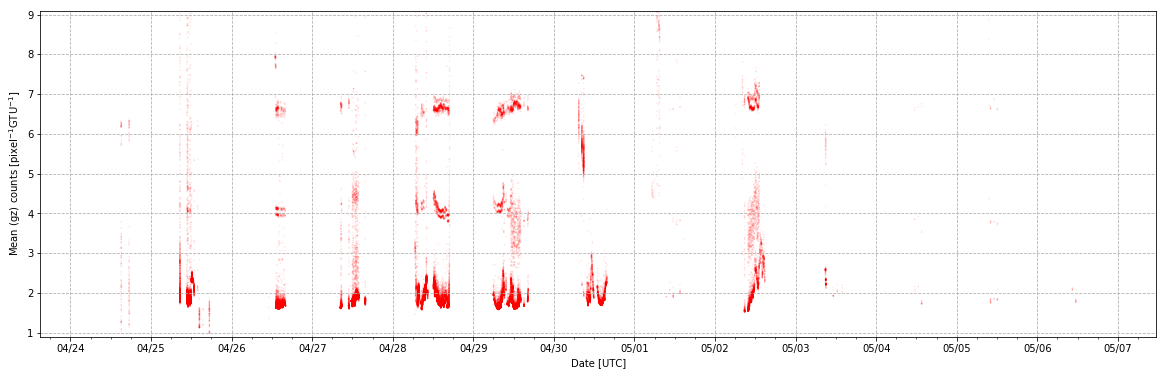

In [70]:
vis_trigger_rate(
    unl_flight_df__by_datetime['gps_datetime_min'].tolist(), 
    unl_flight_df__by_datetime['orig_mean_gz'].tolist(), 
    None,
    ax=None, show=True, ylabel='Mean (gz) counts [pixel$^{-1}$GTU$^{-1}$]',
    marker='.', alpha=.1, color='red', s=10, label=None, yscale='linear',
    ylim=(1,9)
#     ylim=(unl_flight_df__by_datetime['orig_mean_gz'].min(), 
#           unl_flight_df__by_datetime['orig_mean_gz'].quantile(q=0.997))
)

In [64]:
filename_datetime_re = re.compile(r'(\d{4})(\d\d)(\d\d)-(\d\d)(\d\d)(\d\d)-(\d+)\.(\d+)-+(LONG|CHECK)(-sqz(-dis)?)?\.root$')
    
def parse_acq_filename(infile):
    m = filename_datetime_re.search(infile)
    if m:
        bunch = int(m.group(7))
        mode = m.group(9)
        datetime_step = datetime.datetime(
            year=int(m.group(1)), month=int(m.group(2)), day=int(m.group(3)), 
            hour=int(m.group(4)), minute=int(m.group(5)), second=int(m.group(6))
        )
        step_timedelta = datetime.timedelta(seconds=0)
        if mode == 'LONG':
            step_timedelta = datetime.timedelta(seconds=120)
        elif mode == 'CHECK':
            step_timedelta = datetime.timedelta(seconds=40)
        datetime_step_modified = datetime_step + step_timedelta*(bunch-1)
        return bunch, mode, step_timedelta, datetime_step, datetime_step_modified
    return None

def count_trigger_rate_per_file_from_df(unl_flight_df, 
                                        sfa_column='source_file_acquisition', one_trg_per='packet',
                                        datetime_column='gps_datetime_min', packet_id_column='packet_id', 
                                        trg_per_frame_column='trg_size', trg_count_nonzero_column='trg_count_nonzero', 
                                       ):
    
    trigger_rate_list = []
    trigger_datetime_list = []
    
#     filename_type_re = re.compile(r'(\d+)\.(\d+)-+(LONG|CHECK)(-sqz(-dis)?)?\.root$')
    
    unl_flight_sorted_df = unl_flight_df.sort_values([sfa_column, datetime_column], ascending=[True, True])
    unl_flight_groups_df = unl_flight_sorted_df.groupby(sfa_column)

    datetime_step_high = unl_flight_sorted_df.iloc[0][datetime_column]  # generally incorrect, it will be overwritten
 
    for j, (infile, infile_group_df) in enumerate(unl_flight_groups_df):
        p = parse_acq_filename(infile)
        if not p:
            continue
        bunch, mode, step_timedelta, datetime_step, datetime_step_modified = p
        datetime_step_high = datetime_step_modified
        
    for j, (infile, infile_group_df) in enumerate(unl_flight_groups_df):
        
        print('{:d}/{:d} {}'.format(j+1, len(unl_flight_groups_df), infile))

        p = parse_acq_filename(infile)
        
        if not p:
            print(' > SKIPPING')
            continue        
        
        bunch, length, step_timedelta, datetime_step, datetime_step_modified = p
        
        if bunch < 1:
            print(' > SKIPPING (bunch < 1)')
            continue

        infile_group_sorted_df = infile_group_df #.sort_values(datetime_column, ascending=True)
                
        if datetime_step is None:
            print(' >> unable to extract datetime from filename', infile)
            continue
            
#         datetime_step_high = infile_group_df_sorted[datetime_column].iloc[0] + step_timedelta
#         last_datetime_step_start = infile_group_df_sorted[datetime_column].iloc[0]
        
        cur_trigger_num_per_step = 0
        
        if one_trg_per == 'packet':
            for packet_id, packet_group_df in infile_group_sorted_df.groupby(packet_id_column):
                cur_trigger_num_per_step += 1
        else:
            for ind, row in infile_group_sorted_df.iterrows():
                if one_trg_per == 'event':
                    cur_trigger_num_per_step += 1
                elif one_trg_per == 'frame':
                    # one trg per frame
                    cur_trigger_num_per_step += row[trg_per_frame_column]
                else:
                    cur_trigger_num_per_step += row[trg_count_nonzero_column]
                    
        trigger_rate_list.append(cur_trigger_num_per_step / step_timedelta.total_seconds())
        trigger_datetime_list.append(datetime_step_modified)
                
#                 cur_trigger_datetime_step = row[datetime_column]
                
#                 if cur_trigger_datetime_step >= datetime_step_high:
                    
#                     trigger_rate_list.append(cur_trigger_num_per_step / step_timedelta.total_seconds())
#                     trigger_datetime_list.append(last_datetime_step_start)
                    
#                     last_datetime_step_start = datetime_step_high # was cur_trigger_datetime_step 
                    
#                     num_steps = np.floor(
#                         (cur_trigger_datetime_step.total_seconds() - datetime_step_high.total_seconds()) / step_timedelta.total_seconds()
#                     )
                    
#                     datetime_step_high_calc = datetime
                    
#                     print('before while')
#                     while cur_trigger_datetime_step >= datetime_step_high:
#                         datetime_step_high += step_timedelta
#                     print('after while, datetime_step_high=',datetime_step_high, " datetime_step_high_calc=",)

                # endif
            # endfor
        # endfor
    # endfor
    
    return trigger_datetime_list, trigger_rate_list

In [65]:
trigger_datetime_list, trigger_rate_list = count_trigger_rate_per_file_from_df(unl_flight_df)

1/1025 allpackets-SPBEUSO-ACQUISITION-20170424-150143-001.001--CHECK.root
2/1025 allpackets-SPBEUSO-ACQUISITION-20170424-150228-001.001--LONG.root
3/1025 allpackets-SPBEUSO-ACQUISITION-20170424-150228-002.001--LONG.root
4/1025 allpackets-SPBEUSO-ACQUISITION-20170424-150228-003.001--LONG.root
5/1025 allpackets-SPBEUSO-ACQUISITION-20170424-150228-004.001--LONG.root
6/1025 allpackets-SPBEUSO-ACQUISITION-20170424-150228-005.001--LONG.root
7/1025 allpackets-SPBEUSO-ACQUISITION-20170424-172343-001.001--CHECK.root
8/1025 allpackets-SPBEUSO-ACQUISITION-20170424-172427-001.001--LONG.root
9/1025 allpackets-SPBEUSO-ACQUISITION-20170424-172427-002.001--LONG.root
10/1025 allpackets-SPBEUSO-ACQUISITION-20170424-172427-003.001--LONG.root
11/1025 allpackets-SPBEUSO-ACQUISITION-20170424-172427-004.001--LONG.root
12/1025 allpackets-SPBEUSO-ACQUISITION-20170424-172427-005.001--LONG.root
13/1025 allpackets-SPBEUSO-ACQUISITION-20170425-083146-001.001--CHECK.root
14/1025 allpackets-SPBEUSO-ACQUISITION-20170

114/1025 allpackets-SPBEUSO-ACQUISITION-20170427-082554-008.001--LONG-sqz.root
115/1025 allpackets-SPBEUSO-ACQUISITION-20170427-082554-008.001--LONG.root
116/1025 allpackets-SPBEUSO-ACQUISITION-20170427-082554-010.001--LONG-sqz.root
117/1025 allpackets-SPBEUSO-ACQUISITION-20170427-082554-010.001--LONG.root
118/1025 allpackets-SPBEUSO-ACQUISITION-20170427-082554-011.001--LONG-sqz.root
119/1025 allpackets-SPBEUSO-ACQUISITION-20170427-105115-001.001--CHECK.root
120/1025 allpackets-SPBEUSO-ACQUISITION-20170427-105159-001.001--LONG-sqz.root
121/1025 allpackets-SPBEUSO-ACQUISITION-20170427-105159-002.001--LONG-sqz.root
122/1025 allpackets-SPBEUSO-ACQUISITION-20170427-105159-003.001--LONG-sqz.root
123/1025 allpackets-SPBEUSO-ACQUISITION-20170427-105159-004.001--LONG-sqz.root
124/1025 allpackets-SPBEUSO-ACQUISITION-20170427-105159-005.001--LONG-sqz.root
125/1025 allpackets-SPBEUSO-ACQUISITION-20170427-105159-025.001--LONG-sqz-dis.root
126/1025 allpackets-SPBEUSO-ACQUISITION-20170427-105159-025

235/1025 allpackets-SPBEUSO-ACQUISITION-20170427-125407-023.001--LONG-sqz.root
236/1025 allpackets-SPBEUSO-ACQUISITION-20170427-125407-024.001--LONG-sqz-dis.root
237/1025 allpackets-SPBEUSO-ACQUISITION-20170427-125407-024.001--LONG-sqz.root
238/1025 allpackets-SPBEUSO-ACQUISITION-20170427-125407-025.001--LONG-sqz-dis.root
239/1025 allpackets-SPBEUSO-ACQUISITION-20170427-125407-025.001--LONG-sqz.root
240/1025 allpackets-SPBEUSO-ACQUISITION-20170427-125407-026.001--LONG-sqz-dis.root
241/1025 allpackets-SPBEUSO-ACQUISITION-20170427-125407-026.001--LONG-sqz.root
242/1025 allpackets-SPBEUSO-ACQUISITION-20170427-125407-027.001--LONG-sqz-dis.root
243/1025 allpackets-SPBEUSO-ACQUISITION-20170427-125407-028.001--LONG-sqz-dis.root
244/1025 allpackets-SPBEUSO-ACQUISITION-20170427-125407-028.001--LONG-sqz.root
245/1025 allpackets-SPBEUSO-ACQUISITION-20170427-125407-029.001--LONG-sqz-dis.root
246/1025 allpackets-SPBEUSO-ACQUISITION-20170427-125407-029.001--LONG-sqz.root
247/1025 allpackets-SPBEUSO-

345/1025 allpackets-SPBEUSO-ACQUISITION-20170428-130811-006.001--LONG.root
346/1025 allpackets-SPBEUSO-ACQUISITION-20170428-130811-007.001--LONG.root
347/1025 allpackets-SPBEUSO-ACQUISITION-20170428-130811-008.001--LONG.root
348/1025 allpackets-SPBEUSO-ACQUISITION-20170428-130811-009.001--LONG.root
349/1025 allpackets-SPBEUSO-ACQUISITION-20170428-130811-010.001--LONG.root
350/1025 allpackets-SPBEUSO-ACQUISITION-20170428-130811-011.001--LONG.root
351/1025 allpackets-SPBEUSO-ACQUISITION-20170428-130811-012.001--LONG.root
352/1025 allpackets-SPBEUSO-ACQUISITION-20170428-130811-013.001--LONG.root
353/1025 allpackets-SPBEUSO-ACQUISITION-20170428-130811-014.001--LONG.root
354/1025 allpackets-SPBEUSO-ACQUISITION-20170428-130811-015.001--LONG.root
355/1025 allpackets-SPBEUSO-ACQUISITION-20170428-130811-016.001--LONG.root
356/1025 allpackets-SPBEUSO-ACQUISITION-20170428-130811-017.001--LONG.root
357/1025 allpackets-SPBEUSO-ACQUISITION-20170428-130811-018.001--LONG.root
358/1025 allpackets-SPBEU

463/1025 allpackets-SPBEUSO-ACQUISITION-20170429-070031-028.001--LONG.root
464/1025 allpackets-SPBEUSO-ACQUISITION-20170429-070031-029.001--LONG.root
465/1025 allpackets-SPBEUSO-ACQUISITION-20170429-070031-030.001--LONG.root
466/1025 allpackets-SPBEUSO-ACQUISITION-20170429-080051-001.001--CHECK.root
467/1025 allpackets-SPBEUSO-ACQUISITION-20170429-080135-001.001--LONG.root
468/1025 allpackets-SPBEUSO-ACQUISITION-20170429-080135-002.001--LONG.root
469/1025 allpackets-SPBEUSO-ACQUISITION-20170429-080135-003.001--LONG.root
470/1025 allpackets-SPBEUSO-ACQUISITION-20170429-080135-004.001--LONG.root
471/1025 allpackets-SPBEUSO-ACQUISITION-20170429-080135-005.001--LONG.root
472/1025 allpackets-SPBEUSO-ACQUISITION-20170429-080135-006.001--LONG.root
473/1025 allpackets-SPBEUSO-ACQUISITION-20170429-080135-007.001--LONG.root
474/1025 allpackets-SPBEUSO-ACQUISITION-20170429-080135-008.001--LONG.root
475/1025 allpackets-SPBEUSO-ACQUISITION-20170429-080135-009.001--LONG.root
476/1025 allpackets-SPBE

579/1025 allpackets-SPBEUSO-ACQUISITION-20170429-120553-015.001--LONG.root
580/1025 allpackets-SPBEUSO-ACQUISITION-20170429-120553-016.001--LONG-sqz.root
581/1025 allpackets-SPBEUSO-ACQUISITION-20170429-120553-017.001--LONG-sqz.root
582/1025 allpackets-SPBEUSO-ACQUISITION-20170429-120553-019.001--LONG-sqz.root
583/1025 allpackets-SPBEUSO-ACQUISITION-20170429-120553-020.001--LONG-sqz.root
584/1025 allpackets-SPBEUSO-ACQUISITION-20170429-120553-023.001--LONG-sqz.root
585/1025 allpackets-SPBEUSO-ACQUISITION-20170429-120553-024.001--LONG-sqz.root
586/1025 allpackets-SPBEUSO-ACQUISITION-20170429-120553-024.001--LONG.root
587/1025 allpackets-SPBEUSO-ACQUISITION-20170429-120553-025.001--LONG-sqz.root
588/1025 allpackets-SPBEUSO-ACQUISITION-20170429-120553-026.001--LONG-sqz.root
589/1025 allpackets-SPBEUSO-ACQUISITION-20170429-120553-030.001--LONG-sqz.root
590/1025 allpackets-SPBEUSO-ACQUISITION-20170429-130613-001.001--CHECK.root
591/1025 allpackets-SPBEUSO-ACQUISITION-20170429-130657-001.001

692/1025 allpackets-SPBEUSO-ACQUISITION-20170430-105205-021.001--LONG-sqz.root
693/1025 allpackets-SPBEUSO-ACQUISITION-20170430-105205-022.001--LONG-sqz.root
694/1025 allpackets-SPBEUSO-ACQUISITION-20170430-105205-023.001--LONG-sqz.root
695/1025 allpackets-SPBEUSO-ACQUISITION-20170430-105205-024.001--LONG-sqz.root
696/1025 allpackets-SPBEUSO-ACQUISITION-20170430-105205-025.001--LONG-sqz.root
697/1025 allpackets-SPBEUSO-ACQUISITION-20170430-105205-026.001--LONG-sqz.root
698/1025 allpackets-SPBEUSO-ACQUISITION-20170430-105205-027.001--LONG-sqz.root
699/1025 allpackets-SPBEUSO-ACQUISITION-20170430-105205-028.001--LONG-sqz.root
700/1025 allpackets-SPBEUSO-ACQUISITION-20170430-105205-029.001--LONG-sqz.root
701/1025 allpackets-SPBEUSO-ACQUISITION-20170430-105205-030.001--LONG-sqz.root
702/1025 allpackets-SPBEUSO-ACQUISITION-20170430-115225-001.001--CHECK.root
703/1025 allpackets-SPBEUSO-ACQUISITION-20170430-125414-001.001--LONG-sqz.root
704/1025 allpackets-SPBEUSO-ACQUISITION-20170430-125414

863/1025 allpackets-SPBEUSO-ACQUISITION-20170502-094518-008.001--LONG-sqz.root
864/1025 allpackets-SPBEUSO-ACQUISITION-20170502-094518-009.001--LONG-sqz.root
865/1025 allpackets-SPBEUSO-ACQUISITION-20170502-094518-010.001--LONG-sqz.root
866/1025 allpackets-SPBEUSO-ACQUISITION-20170502-094518-011.001--LONG-sqz.root
867/1025 allpackets-SPBEUSO-ACQUISITION-20170502-094518-012.001--LONG-sqz.root
868/1025 allpackets-SPBEUSO-ACQUISITION-20170502-094518-013.001--LONG-sqz.root
869/1025 allpackets-SPBEUSO-ACQUISITION-20170502-094518-014.001--LONG-sqz.root
870/1025 allpackets-SPBEUSO-ACQUISITION-20170502-094518-015.001--LONG-sqz.root
871/1025 allpackets-SPBEUSO-ACQUISITION-20170502-094518-016.001--LONG-sqz.root
872/1025 allpackets-SPBEUSO-ACQUISITION-20170502-094518-017.001--LONG-sqz.root
873/1025 allpackets-SPBEUSO-ACQUISITION-20170502-094518-018.001--LONG-sqz.root
874/1025 allpackets-SPBEUSO-ACQUISITION-20170502-094518-019.001--LONG-sqz.root
875/1025 allpackets-SPBEUSO-ACQUISITION-20170502-094

1008/1025 allpackets-SPBEUSO-ACQUISITION-20170502-134901-030.001--LONG-sqz.root
1009/1025 allpackets-SPBEUSO-ACQUISITION-20170502-144913-001.001--CHECK.root
1010/1025 allpackets-SPBEUSO-ACQUISITION-20170503-085415-001.001--CHECK.root
1011/1025 allpackets-SPBEUSO-ACQUISITION-20170503-085728-001.001--CHECK.root
1012/1025 allpackets-SPBEUSO-ACQUISITION-20170503-090032-001.001--CHECK.root
1013/1025 allpackets-SPBEUSO-ACQUISITION-20170503-111308-001.001--CHECK.root
1014/1025 allpackets-SPBEUSO-ACQUISITION-20170503-122552-001.001--CHECK.root
1015/1025 allpackets-SPBEUSO-ACQUISITION-20170503-135121-001.001--CHECK.root
1016/1025 allpackets-SPBEUSO-ACQUISITION-20170504-113024-001.001--CHECK.root
1017/1025 allpackets-SPBEUSO-ACQUISITION-20170504-123121-001.001--CHECK.root
1018/1025 allpackets-SPBEUSO-ACQUISITION-20170504-133219-001.001--CHECK.root
1019/1025 allpackets-SPBEUSO-ACQUISITION-20170505-093704-001.001--CHECK.root
1020/1025 allpackets-SPBEUSO-ACQUISITION-20170505-100211-001.001--CHECK.r

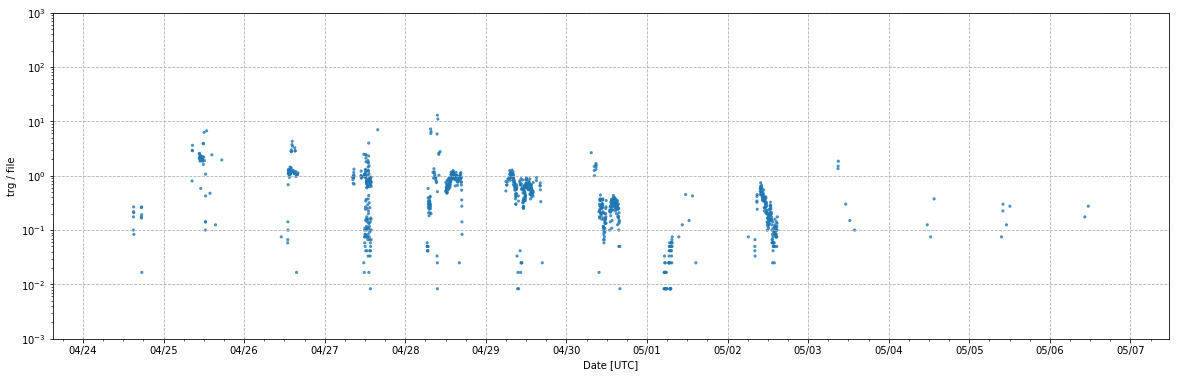

In [71]:
vis_trigger_rate(
    trigger_datetime_list, 
    trigger_rate_list, 
    None, ax=None, show=True, ylabel='trg / file',
    marker='o', alpha=.8, color=None, s=10, label=None, yscale='log',
    ylim=(10**(-2.5), 10**(2.5))
#     ylim=(unl_flight_df__by_datetime['orig_mean_gz'].min(), 
#           unl_flight_df__by_datetime['orig_mean_gz'].quantile(q=0.997))
)

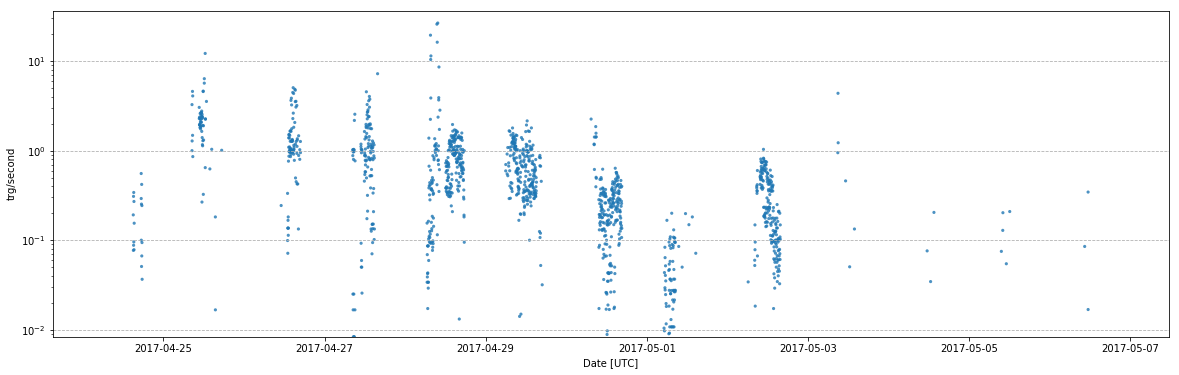

In [42]:
plt_xlim = (np.min(avg_trigger_datetime_steps_list) - datetime.timedelta(days=1), 
             np.max(avg_trigger_datetime_steps_list) + datetime.timedelta(days=1))

plt.figure(figsize=(20, 6))
plt.scatter(avg_trigger_datetime_steps_list, 
            avg_trigger_num_per_step_list, 
            s=10, alpha=.8,
#             alpha=.01,
            cmap=plt.get_cmap('plasma'),
            marker='o', edgecolors='none',
            label='Num triggers per second'
           )
plt.xlim(*plt_xlim)
plt.yscale('log')
# plt.ylim(1e-1, np.max(trigger_num_per_step)+10)
plt.ylim(np.min(avg_trigger_num_per_step_list), np.max(avg_trigger_num_per_step_list)+10)
plt.xlabel('Date [UTC]')
plt.ylabel('trg/second')
plt.gca().grid(which='major', axis='y', linestyle='--')

trigger_rate_v1_scatter_20inch_pathname = \
    os.path.join(data_snippets_dir, 'figures', 'trigger_rate_v1_scatter_20inch.png')
if not os.path.exists(trigger_num_per_second_scatter_20inch_pathname) or recreate_plots:
    plt.savefig(trigger_rate_v1_scatter_20inch_pathname, dpi=150)

plt.show()